In [1]:
import sys
sys.path.append('../src')
sys.path.append('../utils')

import numpy as np
import pandas as pd
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import dtw

from transformers import AddTime, LeadLag
import iisignature
from tools import *
from sigKer_fast import sig_kernel

In [44]:
def transform(paths, at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
#     derivatives = [np.diff(p,axis=0) for p in paths]
#     derivatives = [d/d.max() for d in derivatives]
#     paths = [d.cumsum(0) for d in derivatives]
#     return [p/p.max() for p in paths]
    return paths

In [49]:
np.concatenate([x_train[0],x_train[0]],axis=0)[::-1].shape

(138, 3)

In [62]:
def sig_distance(x,y,n=1):
#     return sig_kernel(x,x,n,implicit=False) + sig_kernel(y,y,n,implicit=False) - 2.*sig_kernel(x,y,n,implicit=False)
    z = np.concatenate([x[::-1],y],axis=0)
    return sig_kernel(z,z,n)

In [51]:
data = UCR_UEA_datasets().list_multivariate_datasets()

k = 7
name = data[k]
print(name)

x_train, y_train, x_test, y_test = UCR_UEA_datasets().load_dataset(data[k])

sub_t = 3
sub_nb = 5

x_train = x_train[::sub_nb,::sub_t,:]
y_train = y_train[::sub_nb]
x_test = x_test[::sub_nb,::sub_t,:]
y_test = y_test[::sub_nb]

print(x_train.shape)
print(x_test.shape)

Epilepsy
(28, 69, 3)
(28, 69, 3)


In [68]:
scale = 0.1
at = False
ll = False
x_train = scale*np.array(transform(x_train, at=at, ll=ll))
x_test = scale*np.array(transform(x_test, at=at, ll=ll))
l = x_train.shape[1]

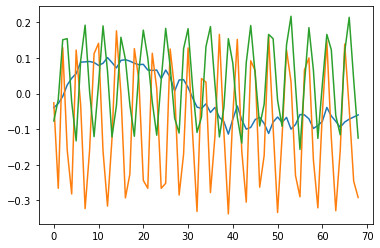

In [69]:
plt.plot(x_train[1])
plt.show()

In [70]:
np.unique(y_train)

array(['EPILEPSY', 'RUNNING', 'SAWING', 'WALKING'], dtype='<U8')

In [71]:
M,N,n = x_train.shape[0], x_test.shape[0], 0

In [72]:
train_matrix_sig = np.zeros((M,M), dtype=np.float64)
train_matrix_dtw = np.zeros((M,M), dtype=np.float64)

test_matrix_sig = np.zeros((N,M), dtype=np.float64)
test_matrix_dtw = np.zeros((N,M), dtype=np.float64)

for i in tqdm.tqdm(range(M)):
    for j in range(M):
        train_matrix_sig[i,j] = sig_distance(x_train[i], x_train[j], n)
        train_matrix_dtw[i,j] = dtw(x_train[i], x_train[j])
    for k in range(N):
        test_matrix_sig[k,i] = sig_distance(x_train[i], x_test[k], n)
        test_matrix_dtw[k,i] = dtw(x_train[i], x_test[k])

In [73]:
train_matrix_sig

array([[1.0000467 , 1.33436787, 1.02948601, 1.02258735, 1.10929592,
        1.05069376, 1.0280563 , 1.00413013, 1.01813692, 1.02416955,
        1.04346276, 1.03392279, 1.0455528 , 1.02779845, 1.05676458,
        1.0418524 , 1.0846743 , 1.08715513, 1.18423536, 1.08452749,
        1.07413096, 1.01892465, 1.04729571, 1.0096608 , 1.03575796,
        1.04264837, 1.05721664, 1.03123339],
       [1.35422559, 1.00416046, 1.47305283, 1.33470302, 1.73131334,
        1.39678396, 1.42928696, 1.40293965, 1.42047111, 1.44313669,
        1.40209379, 1.38384648, 1.38483278, 1.36738589, 1.41226057,
        1.33971722, 1.45559871, 1.36497411, 1.87987153, 1.41643032,
        1.32846368, 1.33112815, 1.42893055, 1.34651578, 1.39934681,
        1.42021521, 1.47755074, 1.37542248],
       [1.02864587, 1.46523565, 1.00051666, 1.04539443, 1.13438263,
        1.04309182, 1.00194947, 1.01264786, 1.00395021, 1.00714624,
        1.0420268 , 1.0399964 , 1.05472922, 1.03527824, 1.07690739,
        1.06033172, 1.0880

In [74]:
clf_sig = KNeighborsClassifier(n_neighbors=1)
clf_sig.fit(train_matrix_sig, y_train)
predictions = clf_sig.predict(test_matrix_sig)
score_sig = accuracy_score(predictions, y_test)
print(score_sig)

0.5357142857142857


In [65]:
clf_dtw = KNeighborsClassifier(n_neighbors=1)
clf_dtw.fit(train_matrix_dtw, y_train)
predictions = clf_dtw.predict(test_matrix_dtw)
score_dtw = accuracy_score(predictions, y_test)
print(score_dtw)

0.9285714285714286


In [384]:
final_results = {}

# standard kernels
for ker in tqdm.tqdm(['linear', 'poly', 'rbf']):
    if ker == 'poly':
        for d in range(2, 5):
            clf = SVC(C=2000, kernel=ker, degree=d, decision_function_shape='ovo', gamma='auto')
            clf.fit([c.reshape(-1) for c in x_train], y_train)
            predictions = clf.predict([c.reshape(-1) for c in x_test])
            final_results[ker + f'-{d}'] = accuracy_score(predictions, y_test)
    else:
        clf = SVC(C=2000, kernel=ker, decision_function_shape='ovo', gamma='auto')
        clf.fit([c.reshape(-1) for c in x_train], y_train)
        predictions = clf.predict([c.reshape(-1) for c in x_test])
        final_results[ker] = accuracy_score(predictions, y_test)
    
# signature naive kernel
clf = SVC(C=2000, kernel='linear', decision_function_shape='ovo', gamma='auto')
for d in tqdm.tqdm(range(1,5)):
    clf.fit([iisignature.sig(c,d) for c in x_train], y_train)
    predictions = clf.predict([iisignature.sig(c,d) for c in x_test])
    final_results[f'sig-naive-{d}'] = accuracy_score(predictions, y_test)

final_results['sig-PDE'] = max(results_penalty)

# Global alignement kernel
# for gamma in tqdm.tqdm([0.0001, 0.001, 0.01, 0.1, 1.]):
#     clf = TimeSeriesSVC(kernel="gak", gamma=gamma)
#     clf.fit(x_train, y_train)
#     final_results[f'GAK-{np.round(gamma,5)}'] = clf.score(x_test, y_test)

In [385]:
final_csv = pd.DataFrame.from_dict(final_results, orient='index').rename(columns={0:'accuracy (%)'})
print(final_csv)
final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}.csv')

             accuracy (%)
linear           0.916667
poly-2           0.283333
poly-3           0.233333
poly-4           0.233333
rbf              0.916667
sig-naive-1      0.633333
sig-naive-2      0.783333
sig-naive-3      0.816667
sig-naive-4      0.833333
sig-PDE          0.883333
